This script estimates the performance of naive bayes classification in a document-topic model's feature space

In [40]:
%load_ext autoreload
%autoreload 2
import time
start_time = time.time()

import json

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np

import sys
sys.path.append("../libraries/")
from selector import split_data
from semanticClassifiers import docTopTransformer2, doc2Bow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# takes list of text fields (e.g. summary or reviewText fields) and
# tokenizes, removes stop words and stems. Returns result as array of 
# lists, one list per review
def preprocess_data(doc_set):    
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        if not i:
            i = ' '
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        tokens.append('null__') # add a bias term, will work as a kind of prior, important for empty reviews
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

# takes an array of lists as input, product labels, uniq_labels, and ratings,
# and merges lists with matching labels among labels uniq_labels, averages
# reviews belonging to the same, returns merged lists, and averaged ratings
# uniq_labels should typically be np.unique(product labels), however 
# the option of specifying a subset is useful for parallelization to allow
# different subsets to be processed by different engines
def combine_reviews(text, asins, ratings):
        products = [asins[0]]
        combined_text = [text[0]]
        average_rating = []
        total_rating = ratings[0]
        count = 1

        #combine all the summaries into a single text and avg the review ratings for each product
        for i in range(1, len(asins)):
            last_element_index = len(products) - 1
            if(asins[i] == products[last_element_index]):
                combined_text[last_element_index] = combined_text[last_element_index] + text[i]
                total_rating += ratings[i]
                count += 1
            else:
                average_rating.append(total_rating/count)
                products.append(asins[i])
                combined_text.append(text[i])
                total_rating = ratings[i]
                count = 1
        average_rating.append(total_rating/count)
        
        return (combined_text, products, average_rating)

In [42]:
# Read in testing data for 80/20 split
# we won't use val_dat at all
json_dat, val_dat = split_data('../data/Sports_and_Outdoors_Reviews_training.json', 80)
#json_dat = json_dat[:1000000]

#sort test data by asin
json_dat = sorted(json_dat, key=lambda k: k['asin'])

In [43]:
# create a list, doc_list, with one review per elem
review = []
summary = []
rating = []
prod_id = []
for i in range(0,len(json_dat)):
    rating.append(json_dat[i].get('overall'))
    summary.append(json_dat[i].get('summary'))
    review.append(json_dat[i].get('reviewText'))
    prod_id.append(json_dat[i].get('asin'))

In [44]:
# takes ~96 CPU minutes

# this cell runs things in parallel. make sure to start an 
# ipython cluster from the notebook dashboard's IPython Cluster
# tab before running
import ipyparallel as ipp

rc = ipp.Client()
dview = rc[:]
dview.execute('from nltk.tokenize import RegexpTokenizer;' +
              'from nltk.corpus import stopwords; ' + 
              'from nltk.stem.porter import PorterStemmer;' +
              'import numpy as np;')

t0 = time.time()


# clean text
dview.push(dict(preprocess_data=preprocess_data))
dview.scatter('summary', summary) # partitions data

%px cleaned_reviews = preprocess_data(summary)
cleaned_reviews = dview.gather('cleaned_reviews').get()

# combine text
total_text, uniq_prod_id, avg_ratings = combine_reviews(cleaned_reviews, prod_id, rating)


t1 = time.time()

print(t1-t0)

68.22944235801697


In [45]:
#parallel_avg_ratings = avg_ratings
#parallel_total_text = total_text

In [46]:
# uncomment this box to run serially

#cleaned_reviews = preprocess_data(summary)
#uniq_prod_id = np.unique(prod_id)
#total_text, avg_ratings = combine_reviews(cleaned_reviews, prod_id, uniq_prod_id, rating)

In [47]:
#print(parallel_avg_ratings == avg_ratings)
#all([all(parallel_total_text[i] == text) for i, text in enumerate(total_text)])

In [48]:
import gc

del summary
del review
del json_dat
del val_dat

gc.collect()

888

In [49]:
# vectorize training data
train_lbls = np.array(avg_ratings) >= 4.5
train_text = total_text

In [50]:
len(train_text)

67338

In [57]:
# estimate classifier accuracy
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, FunctionTransformer

# GroupKFold gives you a KFold partitioner that abides by
# product labels so that products are only ever in a single
# fold
kf = KFold(n_splits=10)
cv = kf.split(train_text, train_lbls)

time0 = time.time()

# initialize a transformer mapping from bow to latent semantic features
doc2Top = docTopTransformer2()

# initialize a normalization transformer
norm_transformer = Normalizer()

# pick a classifier
baseClf = LogisticRegression()#penalty='elasticnet', solver='saga', l1_ratio=0.5)

params = {
    'C': [10, 15, 20]
}

#estimators = [('projection', doc2Top), ('baseClf', baseClf)]
#semClf = Pipeline(estimators)

grid_LR = GridSearchCV(estimator = baseClf, param_grid = params, scoring = 'f1_macro', 
                       cv = 10, verbose = 1, n_jobs = 1)

n_estimators=10
clf = BaggingClassifier(base_estimator=grid_LR, 
                        bootstrap=False, max_samples = 1.0/n_estimators, n_estimators=n_estimators,
                        n_jobs=1)

# create a pipeline that transforms data to semantic space, 
# and then classifies them by averaging over n_estimators of 
# type baseClf
#
# Note, you could bag over n semantic models too by creating
# a pipeline using bow2Top and baseClf, and then passing that
# in as th base_estimator argument of a BaggingClassifier
# instance. If you think bagging classification of reviews will
# lead to better classification performance for theoretical
# reasons, this would be the way to go, however the purpose
# of bagging here is for to avoid a bypass the slow SVM fitting
# procedure
estimators = [('projection', doc2Top), ('normalization', norm_transformer), ('clf', clf)]
semBagClf = Pipeline(estimators)

# cross validate over the pipeline using group k-fold CV
pred_lbls = cross_val_predict(semBagClf, train_text, train_lbls, cv=cv, n_jobs=4)
time1 = time.time()

print(time1-time0)

685.3761119842529


In [58]:
from sklearn.metrics import classification_report

report = classification_report(train_lbls, pred_lbls)
print('True recall is sensitivity, false recall is specificity')
print(report)

# this is not exactly the same as the average of each CV folds accuracy, 
# but it's close and much faster to compute
acc = 1-np.mean(pred_lbls != train_lbls)
print("Accuracy: %0.3f" % acc)

True recall is sensitivity, false recall is specificity
              precision    recall  f1-score   support

       False       0.77      0.75      0.76     34984
        True       0.74      0.75      0.75     32354

    accuracy                           0.75     67338
   macro avg       0.75      0.75      0.75     67338
weighted avg       0.75      0.75      0.75     67338

Accuracy: 0.754


In [59]:
#clf.n_jobs = 5
clf = BaggingClassifier(base_estimator=grid_LR, 
                        bootstrap=False, max_samples = 1.0/n_estimators, n_estimators=n_estimators,
                        n_jobs=5)

estimators = [('projection', doc2Top), ('normalization', norm_transformer), ('clf', clf)]
semBagClf = Pipeline(estimators)

semBagClf = semBagClf.fit(train_text,train_lbls)

for i in semBagClf[2]:
    print(i.best_estimator_)

LogisticRegression(C=15, random_state=1869002994)
LogisticRegression(C=15, random_state=2053963959)
LogisticRegression(C=20, random_state=1491723018)
LogisticRegression(C=10, random_state=243484954)
LogisticRegression(C=10, random_state=2107636064)
LogisticRegression(C=20, random_state=917343737)
LogisticRegression(C=10, random_state=1284902429)
LogisticRegression(C=20, random_state=1412391327)
LogisticRegression(C=10, random_state=1878402904)
LogisticRegression(C=15, random_state=1410949472)


In [60]:
# save fitted classifier
#
# classifier will project tokenized test data to the pretrained 
# document-topic embedding, apply two SVM classifiers, which may
# be linear, polynomial or RBF kernel classifiers, with various
# hyperparameters, average the results, and give you the 
# resulting prediction. The selected kernels and hyperparameters
# are chosen to optimize f1 score
#import pickle
#with open('linearSVM.clf',mode='wb') as f:
#    pickle.dump(semClf,f)

(array([9.0000e+00, 3.0000e+01, 8.3000e+01, 1.9300e+02, 4.8600e+02,
        2.1840e+03, 4.6910e+03, 1.1126e+04, 2.3415e+04, 2.5121e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

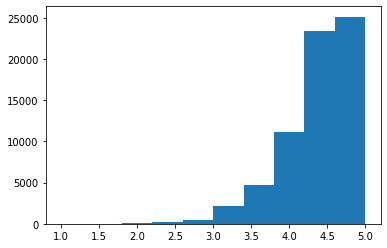

In [61]:
from matplotlib import pyplot as plt
plt.hist(avg_ratings)

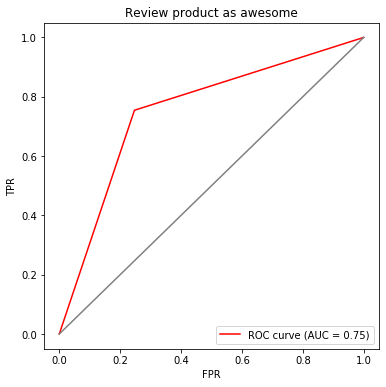

In [62]:
from sklearn.metrics import roc_curve, auc

prod_fpr, prod_tpr, _ = roc_curve(train_lbls, pred_lbls)
prod_auc = auc(prod_fpr, prod_tpr)

xx = prod_fpr
yy = prod_tpr
plt.figure(figsize=[6,6])
plt.plot(xx, yy, label='ROC curve (AUC = %0.2f)' % prod_auc, color='red')
plt.plot([0,1],[0,1],color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Review product as awesome');
plt.legend(loc='lower right')
plt.show()